In [ ]:
## Import libraries
import warnings
warnings.simplefilter(action='ignore')
import os
import zipfile
from shutil import copyfile
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load and extract the dataset
input_path = "/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease.zip"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Plant_Village_Dataset_Corn')
zip_ref.close()

In [ ]:
extrac_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/'

for set_ in ['data']:
  n_common_rust = len(os.listdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Common_rust'))
  n_blight = len(os.listdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Northern_Leaf_Blight'))
  n_gray_leaf_spot = len(os.listdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Cercospora_leaf_spot Gray_leaf_spot'))
  n_health = len(os.listdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___healthy'))
  print('blight images: {}, common rust images: {}, gray leaf spot images: {}, healt images:{}'.format(n_blight,
                                                                                                         n_common_rust,
                                                                                                         n_gray_leaf_spot,
                                                                                                         n_health))

blight images: 985, common rust images: 1192, gray leaf spot images: 513, healt images:1162


In [ ]:
##Create train and test files
try:
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy')

    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy')
except OSError:
    print(file)

In [ ]:
#Split and assign the data into train and test files(80:20)
def split_data(SOURCE, TRAINING, VALIDATION, TESTING):

    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name) # Use os.path.join to create the correct file path


        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point_1 = round(n_files * 0.8)
    split_point_2 = round(n_files * 0.9)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]

    for file_name in train_set:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name)) # Use os.path.join

    for file_name in val_set:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name)) # Use os.path.join

    for file_name in test_set:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name)) # Use os.path.join

Blight_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Northern_Leaf_Blight'
Common_Rust_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Common_rust'
Gray_Leaf_Spot_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___Cercospora_leaf_spot Gray_leaf_spot'
Healthy_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/data/Corn___healthy'

TRAINING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Blight/'
TRAINING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Common_Rust/'
TRAINING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Gray_Leaf_Spot/'
TRAINING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/train/Healthy/'

VALIDATION_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Blight/'
VALIDATION_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Common_Rust/'
VALIDATION_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Gray_Leaf_Spot/'
VALIDATION_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/val/Healthy/'

TESTING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Blight/'
TESTING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Common_Rust/'
TESTING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Gray_Leaf_Spot/'
TESTING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test/Healthy/'


split_data(Blight_SOURCE_DIR, TRAINING_Blight_DIR, VALIDATION_Blight_DIR, TESTING_Blight_DIR)
split_data(Common_Rust_SOURCE_DIR, TRAINING_Common_Rust_DIR, VALIDATION_Common_Rust_DIR, TESTING_Common_Rust_DIR)
split_data(Gray_Leaf_Spot_SOURCE_DIR,TRAINING_Gray_Leaf_Spot_DIR, VALIDATION_Gray_Leaf_Spot_DIR, TESTING_Gray_Leaf_Spot_DIR)
split_data(Healthy_SOURCE_DIR,TRAINING_Healthy_DIR, VALIDATION_Healthy_DIR, TESTING_Healthy_DIR)

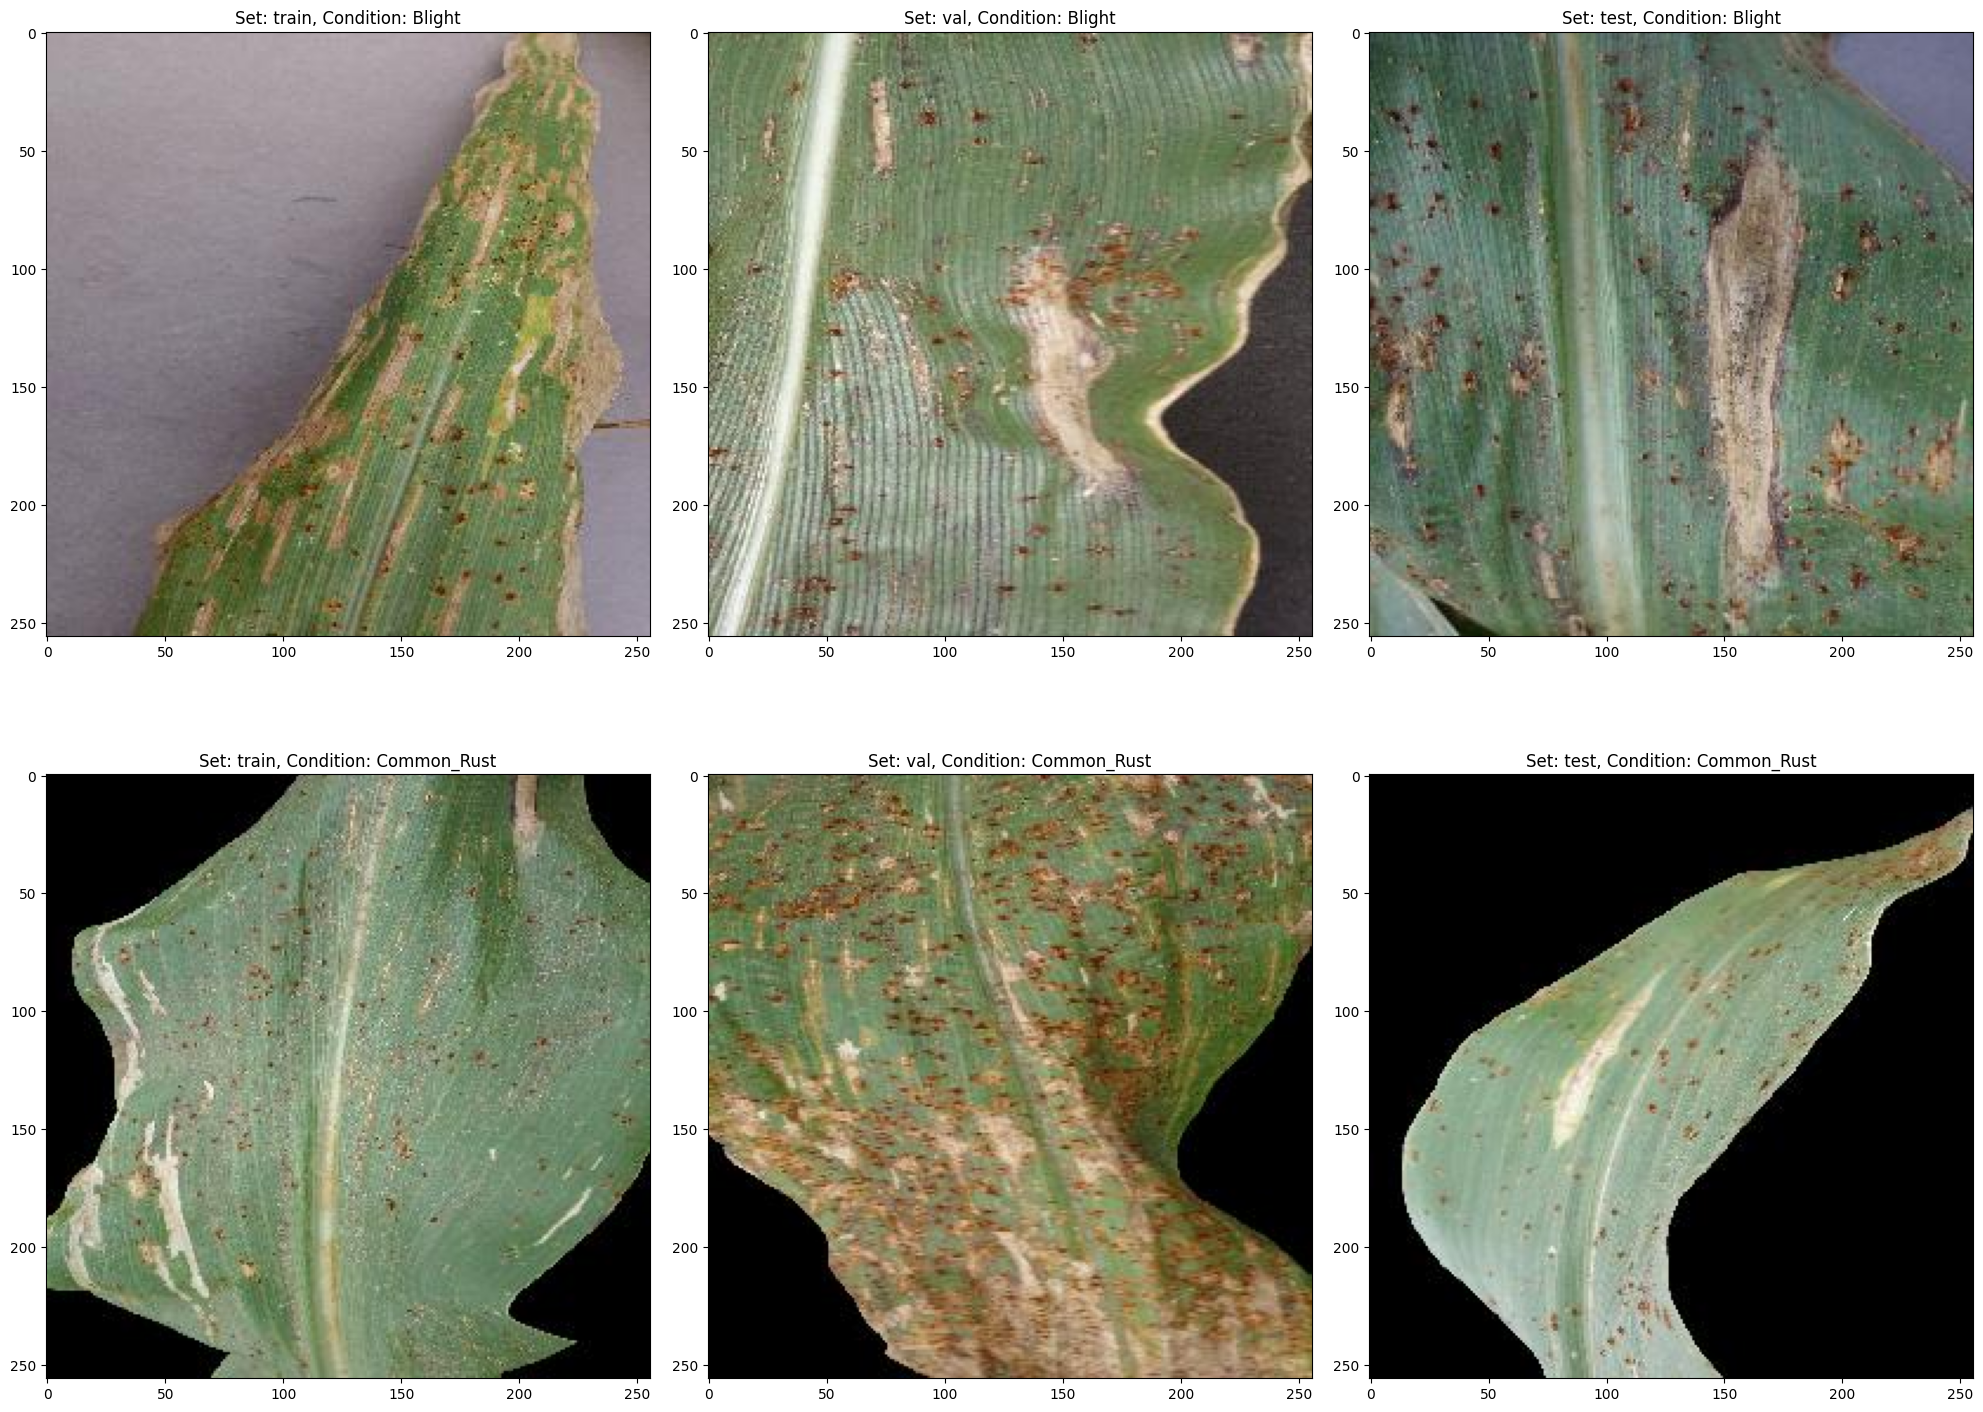

In [ ]:
path_ = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/'

fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val', 'test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Blight/'+os.listdir(set_path+'/Blight')[0]))
    ax[i].set_title('Set: {}, Condition: Blight'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Common_Rust/'+os.listdir(set_path+'/Common_Rust')[0]))
    ax[i+3].set_title('Set: {}, Condition: Common_Rust'.format(set_))

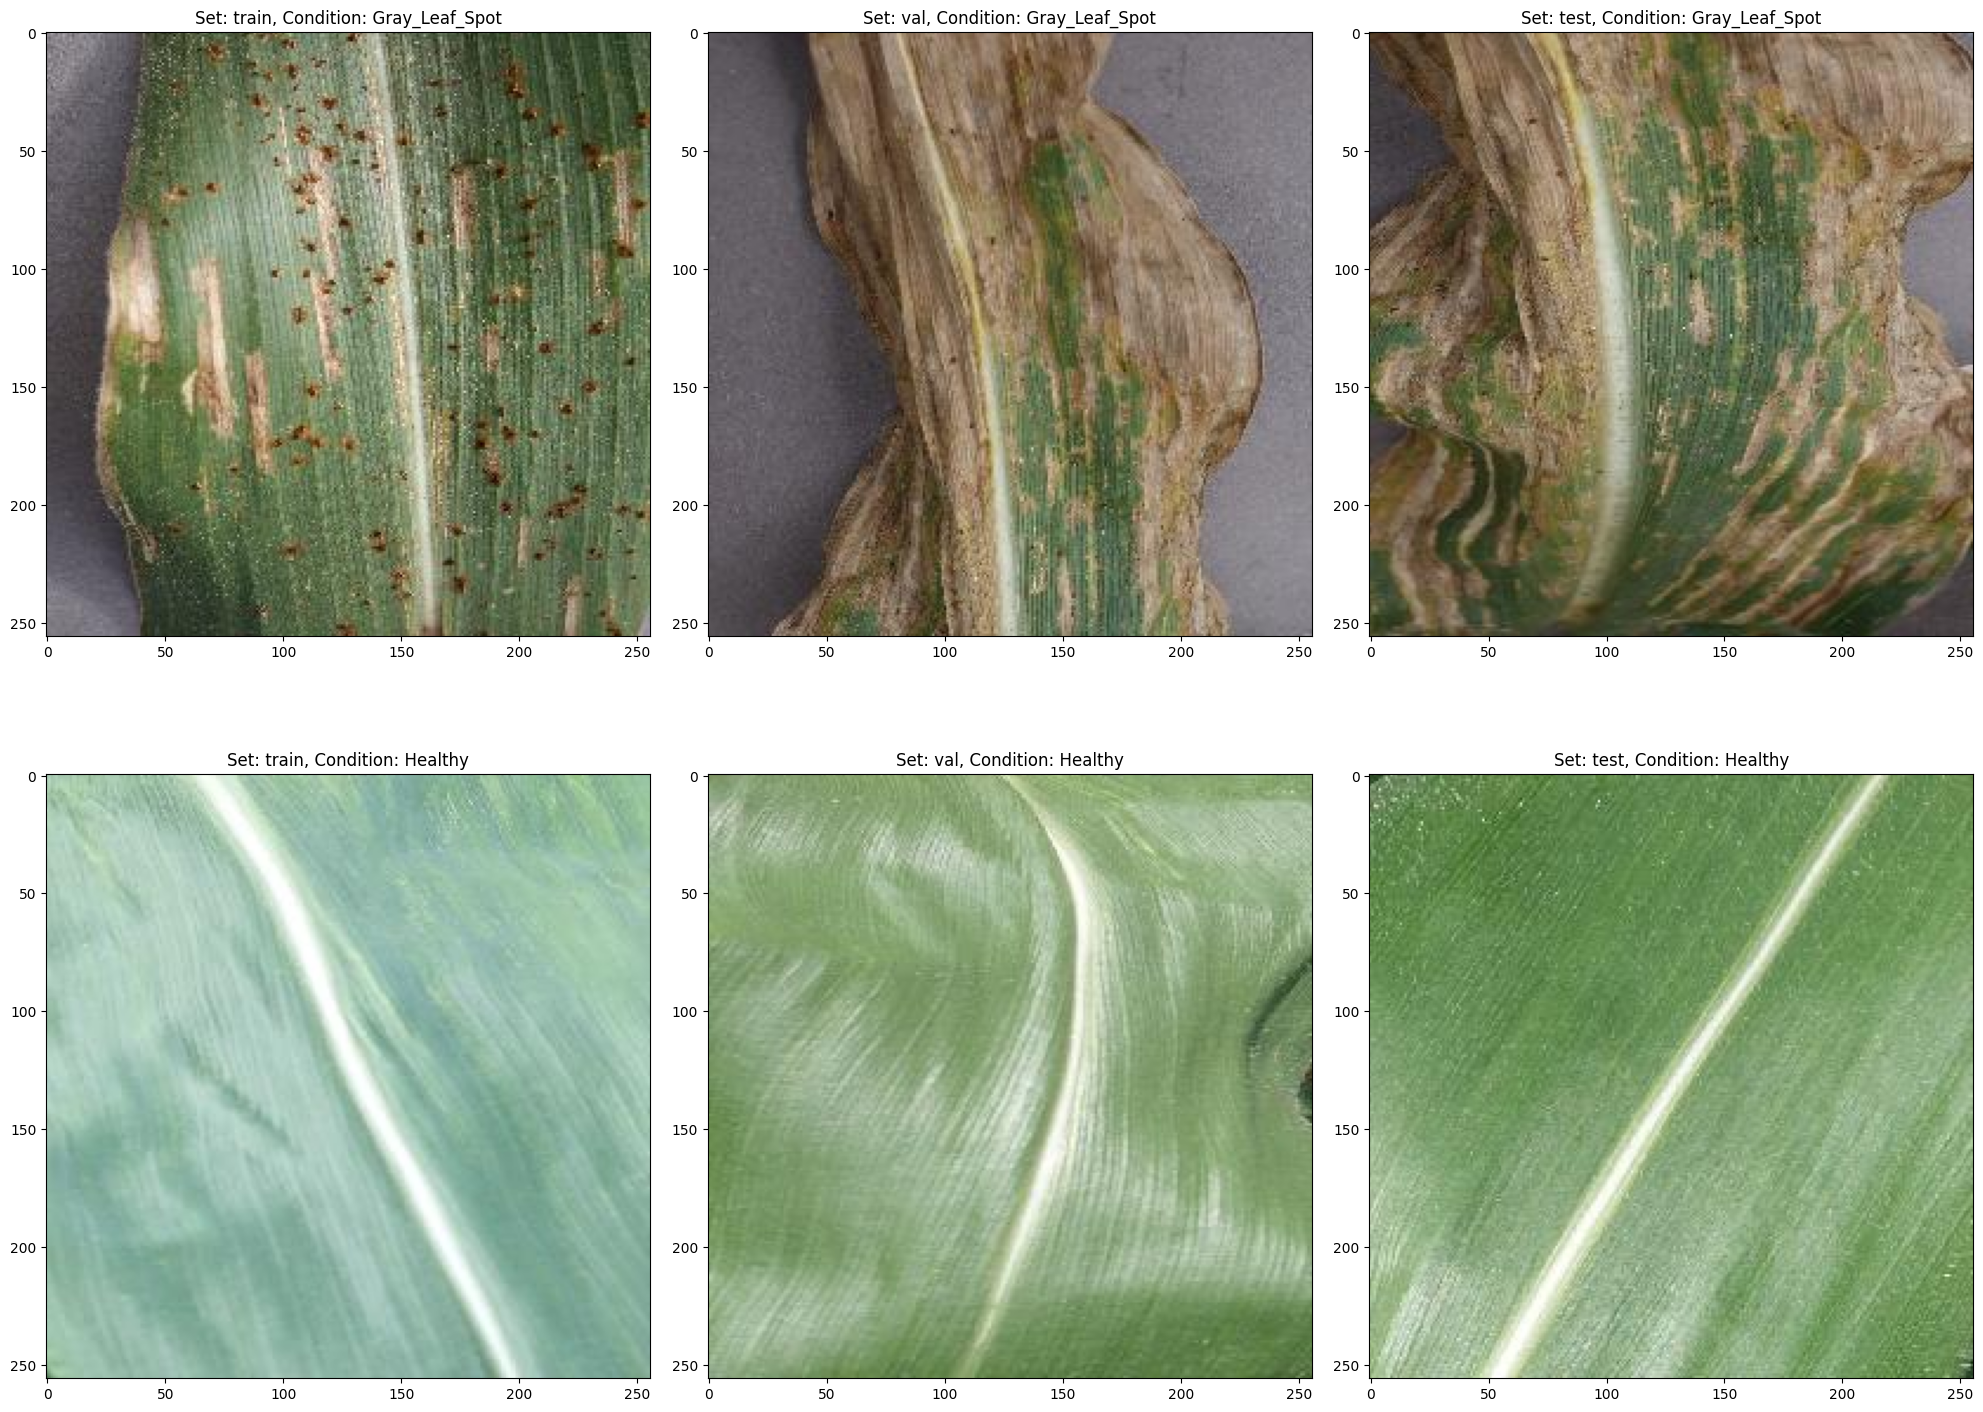

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Gray_Leaf_Spot/'+os.listdir(set_path+'/Gray_Leaf_Spot')[0]))
    ax[i].set_title('Set: {}, Condition: Gray_Leaf_Spot'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Healthy/'+os.listdir(set_path+'/Healthy')[0]))
    ax[i+3].set_title('Set: {}, Condition: Healthy'.format(set_))

In [ ]:
def train_val_test_data(img_dims, batch_size):
  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 40,
                                       width_shift_range = .2,
                                       height_shift_range = .2,
                                       shear_range = .2,
                                       zoom_range = 0.3,
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 1.5],
                                       featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       fill_mode = 'nearest',
                                   )
  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path_ + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = True)
  ## Validation Data
  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator
  val_gen = validation_datagen.flow_from_directory(directory = path_ + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      shuffle = True)
  return train_gen, val_gen

In [ ]:
img_dims = 224
batch_size = 128

train_gen, val_gen = train_val_test_data(img_dims, batch_size)

Found 3082 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('CPU')
print(devices)

## Name divice
name_gpu = "GPU:0"

## Define my strategy like One Device Strategy
strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
def mobilenetv2():

  mobilenet_m = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_dims,img_dims,3),
                                                               include_top = False,
                                                               weights = 'imagenet'
                                                               )
  x = mobilenet_m.trainable = False
  x = mobilenet_m.output
  x = GlobalAveragePooling2D()(x)
  out = Dense(4,activation='softmax')(x)
  model = Model(inputs = mobilenet_m.inputs, outputs = out)
  model.summary()
  return model



In [ ]:
with strategy.scope():

  mobilenetv2_model = mobilenetv2()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = .0001),metrics = ['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs_1 = 50
history_1 = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                               epochs=epochs_1, validation_data=(val_gen),
                               validation_steps=val_gen.samples // batch_size
                                    )


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.4105 - loss: 1.3813 - val_accuracy: 0.5547 - val_loss: 1.1274
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 541ms/step - accuracy: 0.6406 - loss: 1.0644 - val_accuracy: 0.5599 - val_loss: 1.1177
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.5976 - loss: 1.0548 - val_accuracy: 0.6823 - val_loss: 0.9062
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.6000 - loss: 0.9359 - val_accuracy: 0.6875 - val_loss: 0.9002
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.7013 - loss: 0.8510 - val_accuracy: 0.7500 - val_loss: 0.7648
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.7500 - loss: 0.7549 - val_accuracy: 0.7578 - val_loss: 0.7576
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.7834 - loss: 0.7065 - val_accuracy: 0.7917 - val_loss: 0.6681
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 706ms/step - accuracy: 0.8516 - loss: 0.5612 - val_accuracy: 0.

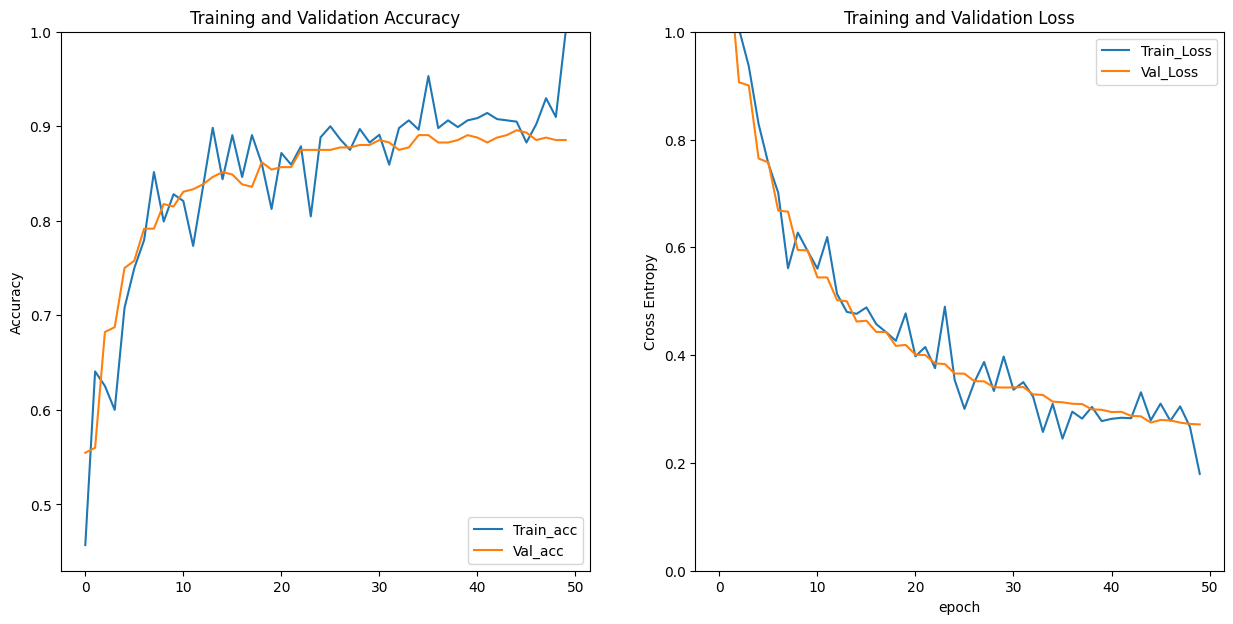

In [ ]:
### Loss and accuracy plot
acc_mob = history_1.history['accuracy']
val_acc_mob = history_1.history['val_accuracy']

loss_mob = history_1.history['loss']
val_loss_mob = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
## Unfreezing layers
mobilenetv2_model.trainable = True

In [ ]:
## Fine-tuning
## number of layer in the pre-trained model
print('Number of layer in the pre-trained model:{}'.format(len(mobilenetv2_model.layers)))
fine_tune_at = 100

for layer in mobilenetv2_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Trainable Layers: {len(mobilenetv2_model.trainable_variables)}")
with strategy.scope():

  mobilenetv2_model.summary()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001/10),metrics = ['accuracy'])
## Training
fine_tune_epochs = 25
total_epochs = epochs_1 + fine_tune_epochs

history_fine = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                                            epochs=total_epochs,
                                            initial_epoch = history_1.epoch[-1],
                                            validation_data=(val_gen),
                                            validation_steps=val_gen.samples // batch_size,
                                    )

Number of layer in the pre-trained model:156
Trainable Layers: 2


In [ ]:
with strategy.scope():

  mobilenetv2_model.summary()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001/10),metrics = ['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

In [ ]:
## Training
fine_tune_epochs = 25
total_epochs = epochs_1 + fine_tune_epochs

history_fine = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                                            epochs=total_epochs,
                                            initial_epoch = history_1.epoch[-1],
                                            validation_data=(val_gen),
                                            validation_steps=val_gen.samples // batch_size,
                                    )

Epoch 50/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.8962 - loss: 0.2784 - val_accuracy: 0.8854 - val_loss: 0.2688
Epoch 51/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.8984 - loss: 0.2572 - val_accuracy: 0.8854 - val_loss: 0.2700
Epoch 52/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9110 - loss: 0.2567 - val_accuracy: 0.8906 - val_loss: 0.2698
Epoch 53/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 730ms/step - accuracy: 0.8672 - loss: 0.3345 - val_accuracy: 0.8906 - val_loss: 0.2646
Epoch 54/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.9108 - loss: 0.2577 - val_accuracy: 0.8880 - val_loss: 0.2686
Epoch 55/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 551ms/step - accuracy: 0.8594 - loss: 0.3062 - val_accuracy: 0.8880 - val_loss: 0.2686
Epoch 56/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.9072 - loss: 0.2636 - val_accuracy: 0.8906 - val_loss: 0.2680
Epoch 57/75
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 708ms/step - accuracy: 0.9141 - loss: 0.2624 - val_accu

In [ ]:
acc_mob += history_fine.history['accuracy']
val_acc_mob += history_fine.history['val_accuracy']

loss_mob += history_fine.history['loss']
val_loss_mob += history_fine.history['val_loss']

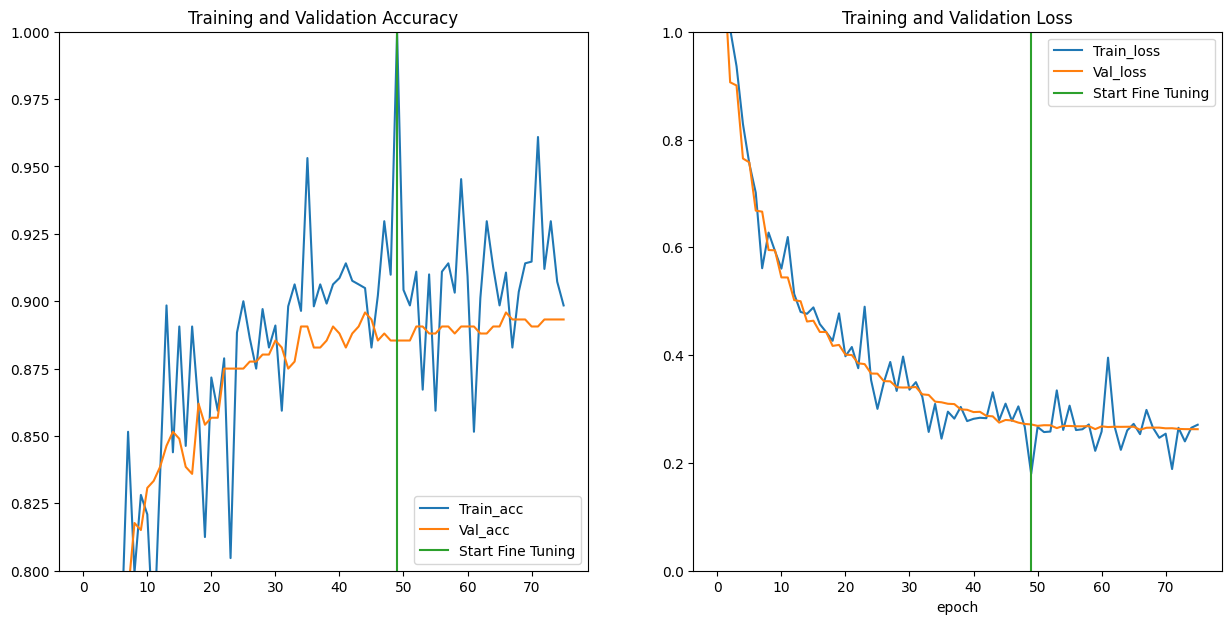

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.ylim([0.8, 1])
plt.plot([epochs_1-1,epochs_1-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_loss')
plt.plot(val_loss_mob, label='Val_loss')
plt.ylim([0, 1.0])
plt.plot([epochs_1-1,epochs_1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
result_eval_f = mobilenetv2_model.evaluate(val_gen, verbose =0)

for metric_, eval_ in zip(mobilenetv2_model.metrics_names, result_eval_f):
  print(metric_ + ': {:.3}'.format(eval_))

loss: 0.262
compile_metrics: 0.894


In [ ]:
## Import the test set
input_test = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Leaf_Disease/test'
labels = os.listdir(input_test)
def get_data(data_dir):
    X = [] # List to store image data
    y = [] # List to store corresponding labels
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                X.append(resized_arr) # Append image data to X
                y.append(class_num) # Append corresponding label to y
            except Exception as e:
                print(e)
    return np.array(X), np.array(y) # Return X and y as NumPy arrays

In [ ]:
test_set_ = get_data(input_test)

# Access the image data and labels from the tuple
X_test = test_set_[0] / 255  # Assuming test_set_[0] contains the image data
y_test = test_set_[1]

In [ ]:
## Prediction
y_pred = np.argmax(mobilenetv2_model.predict(X_test), axis = -1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 851ms/step


Accuracy: 0.906%


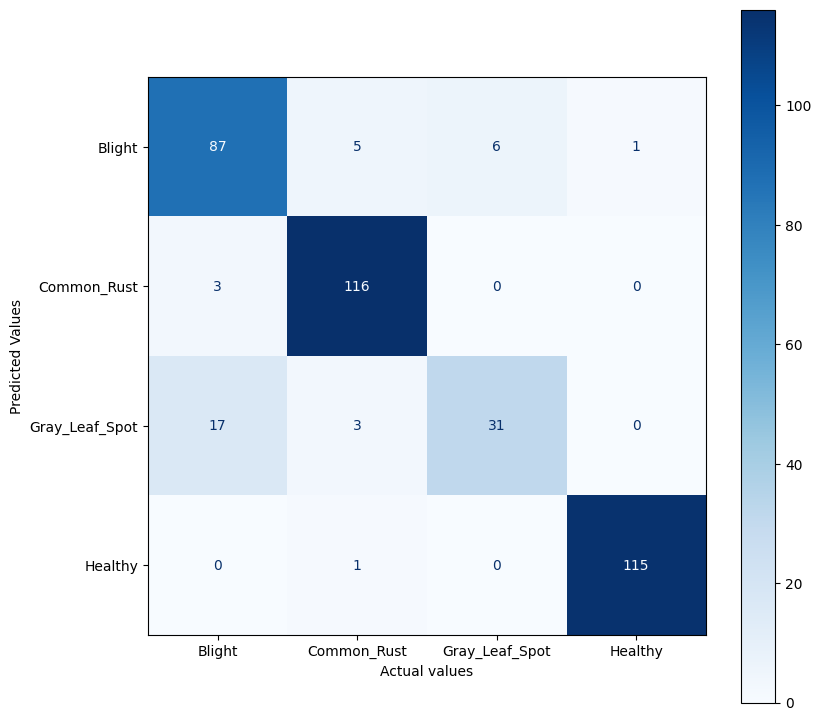

In [ ]:
from sklearn.metrics import accuracy_score

#print("CONFUSION MATRIX ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])
ax.yaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])

## Accuracy and F1-Score
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

In [ ]:
## Save model in HDF5 format
export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2.keras'
mobilenetv2_model.save(export_path) #export_path

Saving corn-leaves.jpg to corn-leaves.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


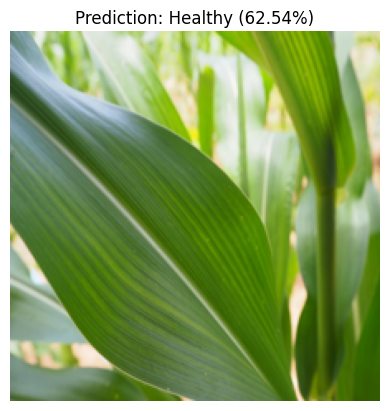

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
model_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2.keras'
model = load_model(model_path)

# Define your class labels (based on your training)
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# Upload image manually or use a path to an image
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename

    # Load and preprocess image
    img = Image.open(img_path).resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (same as during training)

    # Prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

In [ ]:
!pip install streamlit pyngrok

In [ ]:
!pip install streamlit pyngrok --quiet

In [ ]:
app_code = """
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Title and Intro
st.title("🌽 Corn Leaf Diseases Identifier Web App")

st.markdown('''The plant diseases compose a threat to global food security and smallholder farmers whose livelihoods depend mainly on agriculture and healthy crops.
In developing countries, smallholder farmers produce more than 80% of the agricultural production,
and reports indicate that more than fifty percent loss in crop due to pests and diseases.
The world population expected to grow to more than 9.7 billion by 2050, making food security a major concern in the upcoming years. Hence, rapid and accurate methods of indentying plant diseases are needed to do the appropiate measures.''')


# Load model
@st.cache(allow_output_mutation=True)
def load_cnn_model():
    return load_model('/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2.keras')

model = load_cnn_model()

class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image_data = Image.open(uploaded_file).resize((224, 224))
    st.image(image_data, caption='Uploaded Image.', use_column_width=True)

    # Preprocess
    img_array = image.img_to_array(image_data)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    st.subheader(f"Prediction: {predicted_class}")
    st.write(f"Confidence: {confidence*100:.2f}%")
"""

# Save to a file
with open("app.py", "w") as f:
    f.write(app_code)


In [ ]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Set Streamlit port and tunnel it
public_url = ngrok.connect(8501)
print("Your app is live at:", public_url)

# Run the app
!streamlit run corn_app.py &> /dev/null &


Your app is live at: NgrokTunnel: "https://818f-34-80-75-159.ngrok-free.app" -> "http://localhost:8501"
